In [1]:
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
import cv2

image_to_text = pipeline("image-to-text", model="Salesforce/blip2-opt-2.7b", device=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

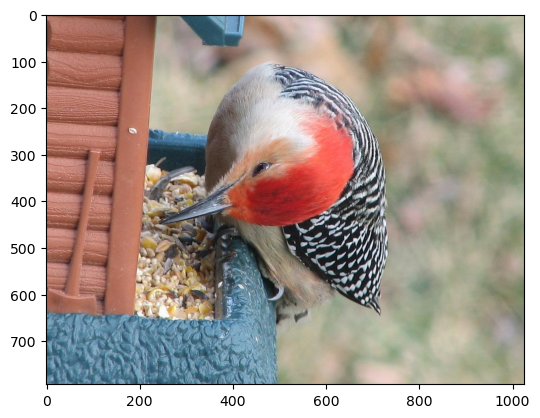

C:\ProgramData\anaconda3\lib\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a red bellied woodpecker eating from a bird feeder\n'}]


In [2]:
img = Image.open("TrainingDataset/TrainingData/Images/6.png")
plt.imshow(img)
plt.show()
print(image_to_text(img))

In [7]:
import os
import pandas as pd 

def read_dataset(anno_path, start_idx=1, end_idx=301):
    anno_dict = dict()
    max_len = dict()
    # Saliency4ASD has 300 images
    for i in range(start_idx,end_idx):
        img = cv2.imread(os.path.join(anno_path,'Images',str(i)+'.png'))
        y_lim, x_lim, _ = img.shape
        anno_dict[i] = dict()
        anno_dict[i]['img_size'] = [y_lim,x_lim]
        asd = pd.read_csv(os.path.join(anno_path,'ASD','ASD_scanpath_'+str(i)+'.txt'))
        ctrl = pd.read_csv(os.path.join(anno_path,'TD','TD_scanpath_'+str(i)+'.txt'))
        group_name = ['ctrl','asd']
        for flag, group in enumerate([ctrl, asd]):
            anno_dict[i][group_name[flag]] = dict()
            anno_dict[i][group_name[flag]]['fixation'] = []
            anno_dict[i][group_name[flag]]['duration'] = []
            cur_idx = list(group['Idx'])
            cur_x = list(group[' x'])
            cur_y = list(group[' y'])
            cur_dur = list(group[' duration'])
            tmp_fix = []
            tmp_dur = []
            for j in range(len(cur_idx)):
                # finish loading data for one subject
                if cur_idx[j] == 0  and j != 0:
                    anno_dict[i][group_name[flag]]['fixation'].append(tmp_fix)
                    anno_dict[i][group_name[flag]]['duration'].append(tmp_dur)
                    tmp_fix = []
                    tmp_dur = []
                tmp_fix.append([cur_y[j],cur_x[j]])
                tmp_dur.append(cur_dur[j])
            # save data of the last subject
            anno_dict[i][group_name[flag]]['fixation'].append(tmp_fix)
            anno_dict[i][group_name[flag]]['duration'].append(tmp_dur)

    return anno_dict

In [71]:
data = read_dataset("TrainingDataset\TrainingData", 1, 301)

In [9]:
fix_seq = data[6]['asd']['fixation'][3]

In [10]:
fx = [f[1] for f in fix_seq]
fy = [f[0] for f in fix_seq]

In [11]:
im_path = "TrainingDataset/TrainingData/Images/6.png"

In [12]:
import numpy as np

In [84]:
crop.shape

(170, 170, 3)

In [129]:
import matplotlib.pyplot as plt
import matplotlib

In [13]:
import matplotlib
font = {'size'   : 7}

matplotlib.rc('font', **font)

In [88]:
def show_crop_seq(img, fixs, crop_radius):
    """
    args: 
        img -> PIL image
        fixs -> sequence of fixations
        crop_radius
    Displays the cropped fixations along with their caption
    """
    
    img = np.array(img)
    h, w, _ = img.shape
    pad = crop_radius
    canvas = np.zeros((h + 2*pad, w + 2*pad, 3), dtype=img.dtype)
    canvas[pad:-pad, pad:-pad, :] = img
    
    fig = plt.figure(figsize=(7, 9))
    columns = 2
    rows = len(fixs)//2 + 1

    # ax enables access to manipulate each of subplots
    ax = []

    for i, fix in enumerate(fixs):
        crop = canvas[fix[0]: fix[0]+ 2*pad, fix[1]: fix[1]+2*pad, :]
        text = image_to_text(Image.fromarray(crop))
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].get_xaxis().set_visible(False)
        ax[-1].get_yaxis().set_visible(False)
        ax[-1].set_title(text[0]['generated_text'])  # set title
        plt.imshow(crop)

    fig.tight_layout()
    plt.show()  # finally, render the plot

In [90]:
fix_seq

[[297, 659], [398, 387], [482, 281], [370, 421], [346, 451]]

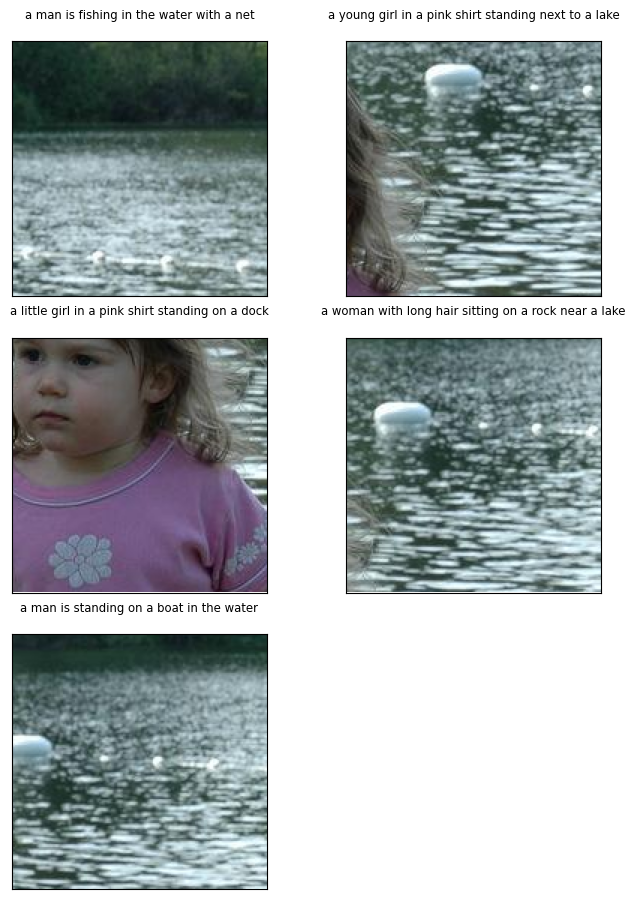

In [89]:
show_crop_seq(img, fix_seq, 85)

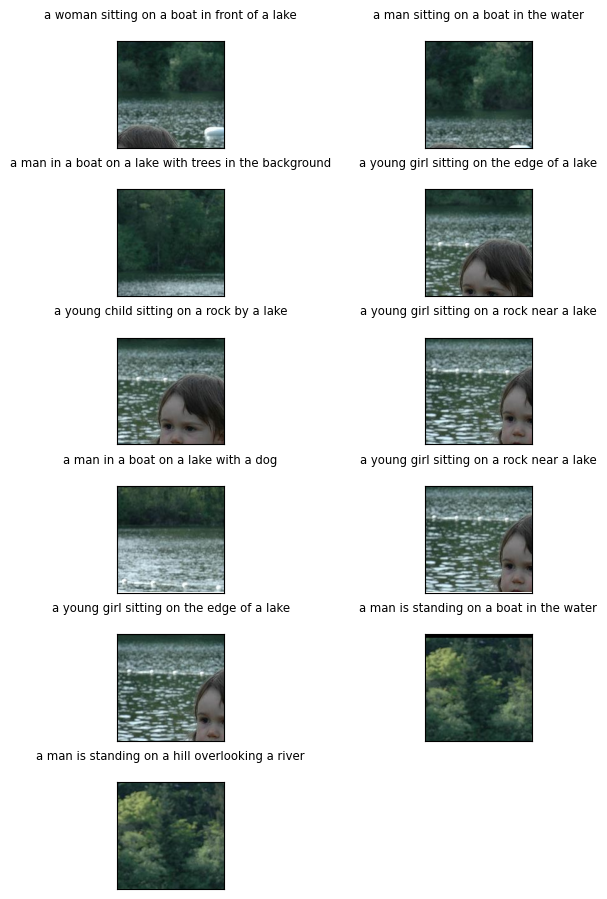

In [20]:
im_path = "TrainingDataset/TrainingData/Images/1.png"
show_crop_seq(Image.open(im_path), data[1]['asd']['fixation'][0], 85)

In [39]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1, 
                                                        output_attentions=False,
                                                        output_hidden_states=False).cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [45]:
inputs = tokenizer("A man is standing on a hill overlooking a river", return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  1037,  2158,  2003,  3061,  2006,  1037,  2940, 12549,  1037,
          2314,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [46]:
for k, v in inputs.items():
    inputs[k] = v.cuda()

In [47]:
out = model.bert(**inputs)

In [48]:
out.pooler_output.size()

torch.Size([1, 768])

In [75]:
def get_crop_captions(img, fixs, crop_radius):
    """
    args: 
        img -> PIL image
        fixs -> sequence of fixations
        crop_radius
    Returns the list of crop captions
    """
    
    img = np.array(img)
    h, w, _ = img.shape
    pad = crop_radius
    canvas = np.zeros((h + 2*pad, w + 2*pad, 3), dtype=img.dtype)
    canvas[pad:-pad, pad:-pad, :] = img
    
    captions = []
    crops = []
    with torch.no_grad():
        for fix in fixs:
            crop = canvas[fix[0]-pad: fix[0]+pad, fix[1]-pad: fix[1]+pad, :]
            crops.append(Image.fromarray(crop))
        
        captions = image_to_text(crops)
        
    return captions

In [76]:
im_path = "TrainingDataset/TrainingData/Images/1.png"
caps = get_crop_captions(Image.open(im_path), data[1]['asd']['fixation'][0], 85)

In [77]:
caps

[[{'generated_text': 'a woman sitting on a boat in front of a lake\n'}],
 [{'generated_text': 'a man sitting on a boat in the water\n'}],
 [{'generated_text': 'a man in a boat on a lake with trees in the background\n'}],
 [{'generated_text': 'a young girl sitting on the edge of a lake\n'}],
 [{'generated_text': 'a young child sitting on a rock by a lake\n'}],
 [{'generated_text': 'a young girl sitting on a rock near a lake\n'}],
 [{'generated_text': 'a man in a boat on a lake with a dog\n'}],
 [{'generated_text': 'a young girl sitting on a rock near a lake\n'}],
 [{'generated_text': 'a young girl sitting on the edge of a lake\n'}],
 [{'generated_text': 'a man is standing on a boat in the water\n'}],
 [{'generated_text': 'a man is standing on a hill overlooking a river\n'}]]

In [65]:
import torch

with torch.no_grad():
    outs = []
    for cap in caps:
        ins = tokenizer(cap, return_tensors='pt')
        for k, v in ins.items():
            ins[k] = v.cuda()
        out = model.bert(**ins)
        outs.append(out.pooler_output)

In [67]:
outs = torch.cat(outs)

In [68]:
outs.size()

torch.Size([11, 768])

In [69]:
len(data[1]['asd']['fixation'][0])

11

In [91]:
from tqdm import tqdm

anno_dict = {i: {} for i in range(1, 301)}
im_dir = "TrainingDataset/TrainingData/Images/"
crop_radius = 85
for i, vals in tqdm(data.items()):
    #print("Image ", i)
    img = Image.open(im_dir + f"{i}.png")
    img = np.array(img)
    h, w, _ = img.shape
    pad = crop_radius
    canvas = np.zeros((h + 2*pad, w + 2*pad, 3), dtype=img.dtype)
    canvas[pad:-pad, pad:-pad, :] = img
    
    anno_dict[i]['ctrl'] = []
    anno_dict[i]['asd'] = []
    for g in ['ctrl', 'asd']:
        #print(" ", g)
        for fixs in vals[g]['fixation']:
            crops = []
            #print("  Starting fixs with len ", len(fixs))
            for fix in fixs:
                cropi = canvas[fix[0]: fix[0]+2*pad, fix[1]: fix[1]+2*pad, :]
                try:
                    crops.append(Image.fromarray(cropi))
                except:
                    print(f"   Cropping failed for {fix}")
            with torch.no_grad():
                captions = image_to_text(crops)
            captions = [c[0]['generated_text'].strip() for c in captions]
            anno_dict[i][g].append(captions)
            #print(f"   Successfull for image {i} and group {g}")

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [5:04:57<00:00, 60.99s/it]


In [92]:
import json

with open('caption_annotations.json', 'w') as f:
    json.dump(anno_dict, f)